## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls  "/content/drive/MyDrive/Colab_notebooks"

 2b-prediction_nn.ipynb   DFL_Schokolade.ipynb	      LinReg.ipynb     models
 data			 'Kopie von ML_task1.ipynb'   ML_task1.ipynb


In [3]:
!pip install keras-tuner

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from kerastuner.tuners import RandomSearch

import tensorflow as tf
from tensorflow import keras

import pickle

print("Here is Tensorflow", tf.__version__)


Here is Tensorflow 2.4.1


In [5]:
## Load data

DEFAULT_DATA_PATH = "/content/drive/MyDrive/Colab_notebooks/"

pickle_in = open(DEFAULT_DATA_PATH + "data/X_train.p", "rb")
X_train = pd.DataFrame(pickle.load(pickle_in))
pickle_in.close()

pickle_in = open(DEFAULT_DATA_PATH + "data/y_train.p", "rb")
y_train = pd.DataFrame(pickle.load(pickle_in))
pickle_in.close()

pickle_in = open(DEFAULT_DATA_PATH + "data/X_test.p", "rb")
X_test = pd.DataFrame(pickle.load(pickle_in))
pickle_in.close()

pickle_in = open(DEFAULT_DATA_PATH + "data/y_test.p", "rb")
y_test = pd.DataFrame(pickle.load(pickle_in))
pickle_in.close()

print("data loaded")

data loaded


In [6]:
## create validation set
# kernel failed by execution
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=123)


In [7]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


# Building the model

In [8]:
# Input Layer: 20 neurons
# hidden Layers: 1 to 5 
# Outplut Layer: 1 Neuron
# Output Activation function: logistic
# Loss function cross entropy

In [9]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[1, 20]))
model.add(keras.layers.Dense(13, activation="relu"))
model.add(keras.layers.Dense(7, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 13)                273       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 98        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 379
Trainable params: 379
Non-trainable params: 0
_________________________________________________________________


In [11]:
# compiling
adam_opt = keras.optimizers.Adam(lr = .01)

model.compile(loss="binary_crossentropy",
    optimizer=adam_opt, 
    metrics=["accuracy"])

In [12]:
# establish call backs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, 
                                                  restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("churn_model.h5", 
                                                save_best_only=True)

# train first model

training_history = model.fit(X_train, y_train, epochs=100, 
                             validation_data=(X_val, y_val), 
                             callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
233/233 [==============================] - 2s 5ms/step - loss: 0.5459 - accuracy: 0.7222 - val_loss: 0.4463 - val_accuracy: 0.7907
Epoch 2/100
233/233 [==============================] - 1s 3ms/step - loss: 0.4692 - accuracy: 0.7686 - val_loss: 0.4382 - val_accuracy: 0.7955
Epoch 3/100
233/233 [==============================] - 1s 3ms/step - loss: 0.4659 - accuracy: 0.7730 - val_loss: 0.4362 - val_accuracy: 0.7950
Epoch 4/100
233/233 [==============================] - 1s 3ms/step - loss: 0.4483 - accuracy: 0.7847 - val_loss: 0.4397 - val_accuracy: 0.7907
Epoch 5/100
233/233 [==============================] - 1s 3ms/step - loss: 0.4511 - accuracy: 0.7850 - val_loss: 0.4317 - val_accuracy: 0.7912
Epoch 6/100
233/233 [==============================] - 1s 3ms/step - loss: 0.4461 - accuracy: 0.7895 - val_loss: 0.4411 - val_accuracy: 0.7907
Epoch 7/100
233/233 [==============================] - 1s 3ms/step - loss: 0.4374 - accuracy: 0.7947 - val_loss: 0.4409 - val_accuracy: 0.7831

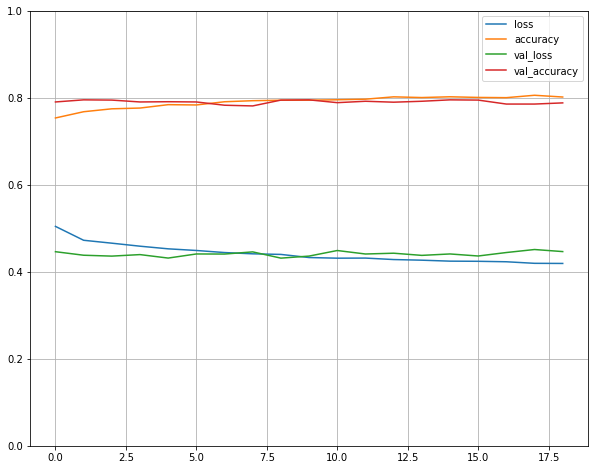

In [13]:
pd.DataFrame(training_history.history).plot(figsize = (10, 8))
plt.grid()
plt.ylim(0,1)
plt.show()

## Hyperparameter tuning

In [21]:
def build_model(hp):
  model_tuned = keras.models.Sequential()
  model_tuned.add(keras.layers.Flatten(input_shape=[20]))
  for layer in range(hp.Int('h_layers',
                            min_value=1,
                            max_value=5,
                            step=1)):
    model_tuned.add(keras.layers.Dense(hp.Int('neurons',
                                              min_value=3,
                                              max_value=18,
                                              step=3), 
                                       activation="relu"))
  model_tuned.add(keras.layers.Dense(1, activation="sigmoid"))

  opt = keras.optimizers.Adam(lr = hp.Choice('learning_rate',
                                             [0.1, 0.01, 0.001, 0.0001]))
  model_tuned.compile(loss="binary_crossentropy", optimizer=opt)
  return model_tuned

In [22]:
# wrap the keras model, so we can tune it like a scikit model

# keras_clas = keras.wrappers.scikit_learn.KerasClassifier(build_model)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=2,
    directory=DEFAULT_DATA_PATH + 'models',
    project_name='telco_model')

In [23]:
# print(tuner.search_space_summary())

tuner.search(x=X_train, y=y_train, epochs=20, validation_data = (X_val, y_val))
print(tuner.results_summary())

Trial 5 Complete [00h 00m 50s]
val_loss: 0.47699520736932755

Best val_loss So Far: 0.43087054044008255
Total elapsed time: 00h 04m 15s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in /content/drive/MyDrive/Colab_notebooks/models/telco_model
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
h_layers: 2
neurons: 9
learning_rate: 0.01
Score: 0.43087054044008255
Trial summary
Hyperparameters:
h_layers: 3
neurons: 6
learning_rate: 0.01
Score: 0.43252476304769516
Trial summary
Hyperparameters:
h_layers: 2
neurons: 9
learning_rate: 0.0001
Score: 0.47699520736932755
Trial summary
Hyperparameters:
h_layers: 4
neurons: 6
learning_rate: 0.0001
Score: 0.5017941072583199
Trial summary
Hyperparameters:
h_layers: 4
neurons: 3
learning_rate: 0.01
Score: 0.5057656839489937
None


As we can see, this hyperparameter tuning is not close to the manually selected params at all. That seems logical to me because in the tuning model, each hidden layer must have the same number of neurons, which leads to a very unorganical network.